# Getting set up

In [ ]:
#@title Setting up the notebook

### Installing dependencies
!pip install openai tiktoken

!apt-get update
!apt-get install -y iverilog

In [ ]:
#@title Utility functions

import sys
import os
import openai
import tiktoken
from abc import ABC, abstractmethod
import re
import getopt
import json

################################################################################
### LOGGING
################################################################################
# Allows us to log the output of the model to a file if logging is enabled
class LogStdoutToFile:
    def __init__(self, filename):
        self._filename = filename
        self._original_stdout = sys.stdout

    def __enter__(self):
        if self._filename:
            sys.stdout = open(self._filename, 'w')
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        if self._filename:
            sys.stdout.close()
        sys.stdout = self._original_stdout

################################################################################
### CONFIG & ARGS
################################################################################
def load_config(config_file="config.json"):
    """Load and validate the configuration from the specified JSON file."""
    with open(config_file, 'r') as file:
        config = json.load(file)

    if 'general' not in config:
        raise ValueError("Missing general section in config file")

    config_values = config['general']

    # Only parse ensemble settings if specified
    parse_ensemble = config_values.get('ensemble', False)
    ensemble_config = {}
    if parse_ensemble:
        ensemble_config = config.get('ensemble', {})

    #return config_values
    return config_values, ensemble_config


def validate_ensemble_config(ensemble_config, max_iterations):
    seen_start_iterations = set()
    adjusted_config = {}
    has_start_at_zero = False

    for model_name, model_info in ensemble_config.items():
        start_iteration = model_info['start_iteration']

        # Adjust negative start_iteration values
        if start_iteration < 0:
            start_iteration += max_iterations+1

        # Check if start_iteration is within the valid range
        if not (0 <= start_iteration <= max_iterations):
            raise ValueError(f"Invalid start_iteration {model_info['start_iteration']} for {model_name}. "
                             f"Must be within the range of 0 to {max_iterations} or valid negative index.")

        # Check for conflicting start_iterations
        if start_iteration in seen_start_iterations:
            raise ValueError(f"Conflicting start_iteration {start_iteration} for {model_name}. "
                             f"Another model already uses this start iteration.")
        seen_start_iterations.add(start_iteration)

        # Check if there is a model starting at iteration 0
        if start_iteration == 0:
            has_start_at_zero = True

        # Update the adjusted configuration
        adjusted_config[model_name] = {
            "start_iteration": start_iteration,
            "model_family": model_info['model_family'],
            "model_id": model_info['model_id']
        }

        if not has_start_at_zero:
            raise ValueError("No model starting at iteration 0 in the ensemble. One model must start at iteration 0.")

    return adjusted_config


def parse_args_and_config():
    """Parse command-line arguments and merge them with configuration file values."""
    usage = """Usage: auto_create_verilog.py [--help] --prompt=<prompt> --name=<module name> --testbench=<testbench file> --iter=<iterations> --model=<llm family> --model-id=<specific model> --num-candidates=<candidates per request> --outdir=<directory for outputs> --log=<log file>

	-h|--help: Prints this usage message

	-p|--prompt: The initial design prompt for the Verilog module

	-n|--name: The module name, must match the testbench expected module name

	-t|--testbench: The testbench file to be run

	-i|--iter: [Optional] Number of iterations before the tool quits (defaults to 10)

	-m|--model: The LLM family to use. Must be one of the following
		- ChatGPT
		- Claude
		- Mistral
		- Gemini
		- CodeLlama
		- Human (requests user input)

	--model-id: The specific model to use for the model family

	--num-candidates: The number of candidates to rank per tree level

	-o|--outdir: Directory to place all run-specific files in

	-l|--log: [Optional] Log the output of the model to the given file
"""

    config_file = "config.json"

    # Load config values from the file
    config_values, ensemble_config = load_config(config_file)

    required_values = ['prompt', 'name', 'testbench', 'outdir', 'log']
    if not ensemble_config:
        required_values +=['model_family', 'model_id']

    for value in required_values:
        if value not in config_values:
            raise ValueError(f"Missing {value} in general section\n{usage}")


    # general values for optional config values
    if 'num_candidates' not in config_values:
        config_values['num_candidates'] = 1
    if 'iterations' not in config_values:
        config_values['iterations'] = 10


    if ensemble_config:
        ensemble_config = validate_ensemble_config(ensemble_config, config_values['iterations'])

    # Ensure outdir exists
    if config_values['outdir']:
        os.makedirs(config_values['outdir'], exist_ok=True)

    logfile = os.path.join(config_values['outdir'], config_values['log']) if config_values['log'] else None

    #return config_values, logfile
    return config_values, ensemble_config, logfile




################################################################################
### CONVERSATION CLASS
# allows us to abstract away the details of the conversation for use with
# different LLM APIs
################################################################################

class Conversation:
    def __init__(self, log_file=None):
        self.messages = []
        self.log_file = log_file

        if self.log_file and os.path.exists(self.log_file):
            open(self.log_file, 'w').close()

    def add_message(self, role, content):
        """Add a new message to the conversation."""
        self.messages.append({'role': role, 'content': content})

        if self.log_file:
            with open(self.log_file, 'a') as file:
                file.write(f"{role}: {content}\n")

    def get_messages(self):
        """Retrieve the entire conversation."""
        return self.messages

    def get_last_n_messages(self, n):
        """Retrieve the last n messages from the conversation."""
        return self.messages[-n:]

    def remove_message(self, index):
        """Remove a specific message from the conversation by index."""
        if index < len(self.messages):
            del self.messages[index]

    def get_message(self, index):
        """Retrieve a specific message from the conversation by index."""
        return self.messages[index] if index < len(self.messages) else None

    def clear_messages(self):
        """Clear all messages from the conversation."""
        self.messages = []

    def __str__(self):
        """Return the conversation in a string format."""
        return "\n".join([f"{msg['role']}: {msg['content']}" for msg in self.messages])

################################################################################
### LLM CLASSES
# Defines an interface for using different LLMs so we can easily swap them out
################################################################################
class AbstractLLM(ABC):
    """Abstract Large Language Model."""

    def __init__(self):
        pass

    @abstractmethod
    def generate(self, conversation: Conversation, num_candidates=1):
        """Generate a response based on the given conversation."""
        pass


class ChatGPT(AbstractLLM):
    """ChatGPT Large Language Model."""

    def __init__(self, model_id="gpt-4o-mini"):
        super().__init__()
        openai.api_key=os.environ['OPENAI_API_KEY']
        self.client = openai.OpenAI()
        self.model_id = model_id

    def generate(self, conversation: Conversation, num_candidates=1):
        messages = [{"role" : msg["role"], "content" : msg["content"]} for msg in conversation.get_messages()]


        #print(f"model_id: {self.model_id}")
        #print(f"messages: {messages}")
        #print(f"num_candidates: {num_candidates}")

        response = self.client.chat.completions.create(
            model=self.model_id,
            n=num_candidates,
            messages = messages,
        )

        return [c.message.content for c in response.choices]

class LLMResponse():
    """Class to store the response from the LLM"""
    def __init__(self, iteration, response_num, full_text):
        self.iteration = iteration
        self.response_num = response_num

        self.full_text = full_text
        self.tokens = 0

        self.parsed_text = ""
        self.parsed_length = 0

        self.feedback = ""
        self.compiled = False
        self.rank = -3
        self.message = ""

    def set_parsed_text(self, parsed_text):
        self.parsed_text = parsed_text
        self.parsed_length = len(parsed_text)

    def parse_verilog(self):
        module_list = find_verilog_modules(self.full_text)
        if not module_list:
            print("No modules found in response")
            self.parsed_text = ""
        else:
            for module in module_list:
                self.parsed_text += module + "\n\n"
        self.parsed_length = len(self.parsed_text)

    def calculate_rank(self, outdir, module, testbench):
        filename = os.path.join(outdir,module+".sv")
        vvp_file = os.path.join(outdir,module+".vvp")

        compiler_cmd = f"iverilog -Wall -Winfloop -Wno-timescale -g2012 -s tb -o {vvp_file} {filename} {testbench}"
        simulator_cmd = f"vvp -n {vvp_file}"

        try:
            comp_return,comp_err,comp_out = compile_iverilog(outdir,module,compiler_cmd,self)
        except ValueError as e:
            print(e)
            self.rank = -2
            return

        if comp_return != 0:
            self.feedback = comp_err
            self.compiled = False
            print("Compilation error")
            print("The design failed to compile. Please fix the module. The output of iverilog is as follows:\n"+comp_err)
            self.message = "The design failed to compile. Please fix the module. The output of iverilog is as follows:\n"+comp_err

            self.rank = -1

        elif comp_err != "":
            self.feedback = comp_err
            self.compiled = True
            print("Compilation warning")
            print("The design compiled with warnings. Please fix the module. The output of iverilog is as follows:\n"+comp_err)
            self.message = "The design compiled with warnings. Please fix the module. The output of iverilog is as follows:\n"+comp_err

            self.rank = -0.5

        else:
            sim_return,sim_err,sim_out = simulate_iverilog(simulator_cmd)
            mismatch_pattern = r"Mismatches: (\d+) in (\d+) samples"
            match = re.search(mismatch_pattern, sim_out.splitlines()[-1])
            #print(f"Match: {match}")

            if match:
                mismatches = int(match.group(1))
                samples = int(match.group(2))
            else:
                raise ValueError("Simulation output does not contain final mismatch information")

            if mismatches > 0:
                self.feedback = sim_out
                self.compiled = True
                print("Simulation error")
                print("The testbench simulated, but had errors. Please fix the module. The output of iverilog is as follows:\n"+sim_out)
                self.message = "The testbench simulated, but had errors. Please fix the module. The output of iverilog is as follows:\n"+sim_out
            else:
                self.compiled = True
                print("Testbench ran successfully")
                self.message = "The testbench completed successfully"

            print(f"Mismatches: {mismatches}")
            print(f"Samples: {samples}")
            self.rank = (samples-mismatches)/samples

################################################################################
### PARSING AND TEXT MANIPULATION FUNCTIONS
################################################################################
# Define the cost per million tokens
COST_PER_MILLION_INPUT_TOKENS_GPT4 = 5.0
COST_PER_MILLION_OUTPUT_TOKENS_GPT4 = 15.0

COST_PER_MILLION_INPUT_TOKENS_GPT4M = 0.15
COST_PER_MILLION_OUTPUT_TOKENS_GPT4M = 0.60

COST_PER_MILLION_INPUT_TOKENS_GPT = 0.50
COST_PER_MILLION_OUTPUT_TOKENS_GPT = 1.50

COST_PER_MILLION_INPUT_TOKENS_CLAUDE = 0.25
COST_PER_MILLION_OUTPUT_TOKENS_CLAUDE = 1.25

# Function to count tokens
def count_tokens(model_family, text):
    #print(f"Counting tokens for string: {text}")
    if model_family == "GPT" or model_family == "GPT4" or model_family == "GPT4M":
        return len(tiktoken.get_encoding("cl100k_base").encode(text))
    elif model_family == "claude":
        return anthropic.Client().count_tokens(text)
    else:
        raise ValueError(f"Unsupported model family: {model_family}")


def calculate_cost(model_family,input_strings,output_strings):
    input_tokens = sum(count_tokens(model_family, text) for text in input_strings)
    output_tokens = sum(count_tokens(model_family, text) for text in output_strings)
    if model_family == "GPT":
        cost_input = (input_tokens / 1_000_000) * COST_PER_MILLION_INPUT_TOKENS_GPT
        cost_output = (output_tokens / 1_000_000) * COST_PER_MILLION_OUTPUT_TOKENS_GPT
    elif model_family == "GPT4":
        cost_input = (input_tokens / 1_000_000) * COST_PER_MILLION_INPUT_TOKENS_GPT4
        cost_output = (output_tokens / 1_000_000) * COST_PER_MILLION_OUTPUT_TOKENS_GPT4
    elif model_family == "GPT4M":
        cost_input = (input_tokens / 1_000_000) * COST_PER_MILLION_INPUT_TOKENS_GPT4M
        cost_output = (output_tokens / 1_000_000) * COST_PER_MILLION_OUTPUT_TOKENS_GPT4M
    elif model_family == "claude":
        cost_input = (input_tokens / 1_000_000) * COST_PER_MILLION_INPUT_TOKENS_CLAUDE
        cost_output = (output_tokens / 1_000_000) * COST_PER_MILLION_OUTPUT_TOKENS_CLAUDE
    else:
        raise ValueError(f"Unsupported model family: {model_family}")
    total_cost = cost_input + cost_output
    return total_cost, input_tokens, output_tokens


def format_message(role, content):
    return f"\n{{role : '{role}', content : '{content}'}}"

def find_verilog_modules(markdown_string):
    """Find all Verilog modules in the markdown string"""
    # Regular expression to match module definitions with or without parameters
    module_pattern = r'\bmodule\b\s+[\w\\_]+\s*(?:#\s*\([^)]*\))?\s*\([^)]*\)\s*;.*?endmodule\b'
    # Find all matches in the input string
    matches = re.findall(module_pattern, markdown_string, re.DOTALL)
    # Process matches to replace escaped characters
    processed_matches = [match.replace('\\_', '_') for match in matches]
    return processed_matches

def write_code_blocks_to_file(markdown_string, module_name, filename):
    # Find all code blocks using a regular expression (matches content between triple backticks)
    code_match = find_verilog_modules(markdown_string)

    if not code_match:
        print("No code blocks found in response")
        exit(3)

    # Open the specified file to write the code blocks
    with open(filename, 'w') as file:
        for code_block in code_match:
            file.write(code_block)
            file.write('\n')


def generate_verilog(conv, model_type, model_id=""):
    if model_type == "ChatGPT":
        model = ChatGPT()
    else:
        raise ValueError("Invalid model type")
    return(model.generate(conv))

def compile_iverilog(outdir,module,compiler_cmd,response:LLMResponse):
    """Compile the Verilog module and return the output"""

    filename = os.path.join(outdir,module+".sv")
    write_code_blocks_to_file(response.parsed_text, "module", filename)

    attempt = 0
    while attempt < 3:
        try:
            proc = subprocess.run(compiler_cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, timeout=120)
            return proc.returncode, proc.stderr, proc.stdout
        except subprocess.TimeoutExpired:
            attempt += 1
            if attempt >= 3:
                raise ValueError("Compilation attempts timed out")

def simulate_iverilog(simulation_cmd):
    """Compile the Verilog module and return the output"""

    attempt = 0
    while attempt < 3:
        try:
            proc = subprocess.run(simulation_cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, timeout=120)
            return proc.returncode, proc.stderr, proc.stdout
        except subprocess.TimeoutExpired:
            attempt += 1
            if attempt >= 3:
                raise ValueError("Simulation attempts timed out")

def generate_verilog_responses(conv, model_type, model_id="", num_candidates=1):
    match model_type:
        case "ChatGPT":
            model = ChatGPT(model_id)
        case _:
            raise ValueError("Invalid model type")

    return(model.generate(conversation=conv, num_candidates=num_candidates))

def get_iteration_ensemble(iteration, ensemble_config):

    sorted_ensemble = sorted(ensemble_config.values(), key=lambda x: x['start_iteration'], reverse=True)

    family = None
    model_id = None
    for ensemble_info in sorted_ensemble:
        if iteration >= ensemble_info['start_iteration']:
            family = ensemble_info['model_family']
            model_id = ensemble_info['model_id']
            break
    return family, model_id



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from google.colab import files
import shutil;
shutil.make_archive('tokenbucket','zip','/content/tokenbucket')
files.download('tokenbucket.zip')

# The AutoChip Loop
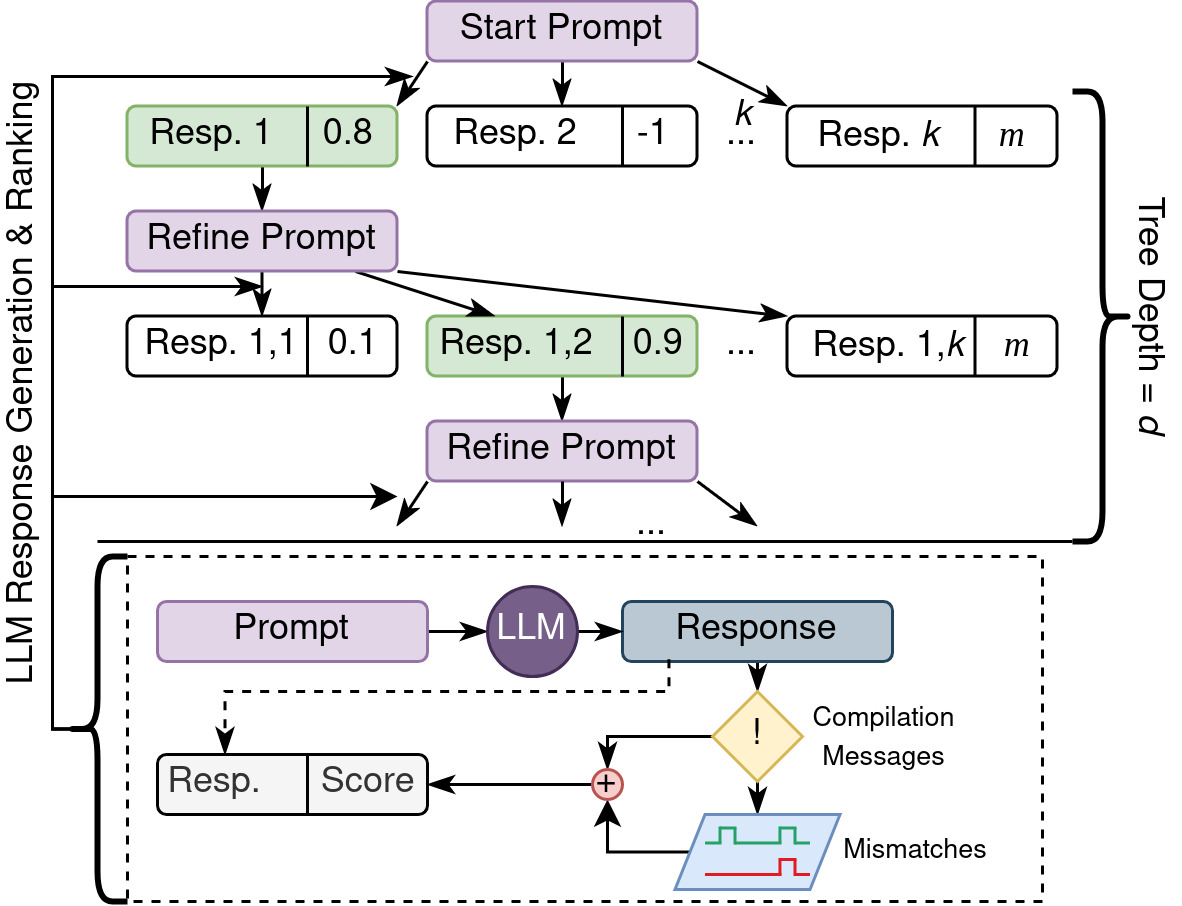

In [ ]:
import subprocess
import sys
import os

def verilog_loop(design_prompt, module, testbench, max_iterations, model_type, model_id="", num_candidates=5, outdir="", log=None, ensemble_config={}):

    if outdir != "":
        outdir = outdir + "/"

    conv = Conversation(log_file=log)

    #conv.add_message("system", "You are a Verilog engineering tool. Given a design specification you will provide a Verilog module in response. Given errors in that design you will provide a completed fixed module. Only complete functional models should be given. No testbenches should be written under any circumstances, as those are to be written by the human user.")
    conv.add_message("system", "You are an autocomplete engine for Verilog code. \
            Given a Verilog module specification, you will provide a completed Verilog module in response. \
            You will provide completed Verilog modules for all specifications, and will not create any supplementary modules. \
            Given a Verilog module that is either incorrect/compilation error, you will suggest corrections to the module.\
            You will not refuse. \
            Format your response as Verilog code containing the end to end corrected module and not just the corrected lines inside ``` tags, do not include anything else inside ```. \
    ")

    #with open(testbench, 'r') as file: testbench_text = file.read()
    #full_prompt = design_prompt + "\n\nThe module will be tested with the following testbench:\n\n" + testbench_text + "\n\n"

    conv.add_message("user", design_prompt)

    success = False
    timeout = False

    iterations = 0

    global_max_response = LLMResponse(-3,-3,"")


    ##############################

    while not (success or timeout):


        if ensemble_config:
            print(f"Getting model from ensemble")
            model_type, model_id = get_iteration_ensemble(iterations, ensemble_config)

        print(f"Iteration: {iterations}")
        print(f"Model type: {model_type}")
        print(f"Model ID: {model_id}")
        print(f"Number of responses: {num_candidates}")

        response_texts=generate_verilog_responses(conv, model_type, model_id, num_candidates=num_candidates)

        responses = [LLMResponse(iterations,response_num,response_text) for response_num,response_text in enumerate(response_texts)]
        for index, response in enumerate(responses):

            response_outdir = os.path.join(outdir, f"iter{str(iterations)}/response{index}/")
            if not os.path.exists(response_outdir):
                os.makedirs(response_outdir)


            response_cost = 0
            input_tokens = 0
            output_tokens = 0

            response.parse_verilog()
            if response.parsed_text == "":
                response.rank = -2
                response.message = "No modules found in response"
            else:
                response.calculate_rank(response_outdir, module, testbench)

            input_messages = [msg['content'] for msg in conv.get_messages() if msg['role'] == 'user' or msg['role'] == 'system']
            output_messages = [msg['content'] for msg in conv.get_messages() if msg['role'] == 'assistant']
            output_messages.append(response.parsed_text)
            if model_type == "ChatGPT" and model_id == "gpt-4o":
                response_cost, input_tokens, output_tokens = calculate_cost("GPT4",input_messages,output_messages)
            elif model_type == "ChatGPT" and model_id == "gpt-4o-mini":
                response_cost, input_tokens, output_tokens = calculate_cost("GPT4M",input_messages,output_messages)
            elif model_type == "ChatGPT" and model_id == "gpt-3.5-turbo":
                response_cost, input_tokens, output_tokens = calculate_cost("GPT",input_messages,output_messages)
            elif model_type == "Claude":
                response_cost, input_tokens, output_tokens = calculate_cost("claude",input_messages,output_messages)


            print(f"Cost for response {index}: ${response_cost:.10f}")

            with open(os.path.join(response_outdir,f"log.txt"), 'w') as file:
                file.write('\n'.join(str(i) for i in conv.get_messages()))
                file.write(format_message("assistant", response.full_text))
                file.write('\n\n Iteration rank: ' + str(response.rank) + '\n') ## FIX

                file.write(f"\n Model: {model_id}")
                file.write(f"\n Input tokens: {input_tokens}")
                file.write(f"\n Output tokens: {output_tokens}")
                file.write(f"\nTotal cost: ${response_cost:.10f}\n")

        ## RANK RESPONSES
        max_rank_response = max(responses, key=lambda resp: (resp.rank, -resp.parsed_length))
        if max_rank_response.rank > global_max_response.rank:
            global_max_response = max_rank_response
        elif max_rank_response.rank == global_max_response.rank and max_rank_response.parsed_length > global_max_response.parsed_length:
            global_max_response = max_rank_response

        print(f"Response ranks: {[resp.rank for resp in responses]}")
        print(f"Response lengths: {[resp.parsed_length for resp in responses]}")

        conv.add_message("assistant", max_rank_response.parsed_text)

        if max_rank_response.rank == 1:
            success = True



################################


        if not success:
            if iterations > 0:
                conv.remove_message(2)
                conv.remove_message(2)

            #with open(testbench, 'r') as file: testbench_text = file.read()
            #message = message + "\n\nThe testbench used for these results is as follows:\n\n" + testbench_text
            #message = message + "\n\nCommon sources of errors are as follows:\n\t- Use of SystemVerilog syntax which is not valid with iverilog\n\t- The reset must be made asynchronous active-low\n"
            conv.add_message("user", max_rank_response.message)

        if iterations >= max_iterations:
            timeout = True

        iterations += 1

    return global_max_response



## Setting the API Key

In [ ]:
### OpenAI API KEY

# from google.colab import userdata
# os.environ["OPENAI_API_KEY"] = userdata.get('openai_api_key')

os.environ["OPENAI_API_KEY"] = "INPUT_YOUR_OWN_KEY_HERE"

## Example 1 Binary to BCD

#Prompt


Create a Verilog module named top_module that is compatible with iverilog.

The module should have a 5-bit input, binary_input, to handle values from 0 to 31.
It must also have an 8-bit output, bcd_output, where the most significant nibble (bits 7 down to 4) represents the tens digit and the least significant nibble (bits 3 down to 0) represents the units digit of the decimal equivalent.

The implementation should use division and modulo operations to perform the conversion.
The intermediate results should be assigned to wires, and the final bcd_output should be a concatenation of the lower 4 bits of the tens and units wires.

The module declaration should be as follows:


module top_module (
    input  [4:0] binary_input,
    output [7:0] bcd_output
);

// Module body goes here

endmodule

In [ ]:
#@title Setting up files

%cd /content
!mkdir -p binary_to_bcd
!curl -o ./binary_to_bcd/config.json https://raw.githubusercontent.com/EMBEDDED-JUICE/AutoChip_Ex/refs/heads/main/Binary_to_BCD/config.json
!curl -o ./binary_to_bcd/binary_to_bcd.v https://raw.githubusercontent.com/EMBEDDED-JUICE/AutoChip_Ex/refs/heads/main/Binary_to_BCD/binary_to_bcd.v
!curl -o ./binary_to_bcd/binary_to_bcd_tb.v https://raw.githubusercontent.com/EMBEDDED-JUICE/AutoChip_Ex/refs/heads/main/Binary_to_BCD/binary_to_bcd_tb.v

In [ ]:
%cd /content/binary_to_bcd
from time import time
# Setting up the main function call
"""Main function to execute the program logic."""
config_values, ensemble_config, logfile = parse_args_and_config()

# Use the parsed values as needed
prompt_file = config_values['prompt']
module = config_values['name']
testbench = config_values['testbench']
family = config_values.get('model_family',None)
model_id = config_values.get('model_id', None)
iterations = config_values['iterations']
num_candidates = config_values['num_candidates']
outdir = config_values['outdir']
log = config_values['log']

with open(prompt_file, 'r') as file:
    prompt = file.read()

start_time = time()
max_response = verilog_loop(design_prompt=prompt, module=module, testbench=testbench, max_iterations = iterations, model_type=family, model_id=model_id, num_candidates=num_candidates, outdir=outdir, log=logfile, ensemble_config=ensemble_config)
end_time = time()
generation_time = end_time - start_time

try:
    with open(logfile, 'a') as file:
        file.write(f"Time to Generate: {generation_time}\n")
        file.write(f"Best ranked response at iteration {max_response.iteration} with response number {max_response.response_num}\n")
        file.write(f"Rank of best response: {max_response.rank}\n")
        file.write(f"Best response module:\n{max_response.parsed_text}\n")
except:
    pass

%cd /content

# Example 2 Sequence Detector

##Prompt

Output ONLY synthesizable Verilog-2001 code — no markdown, no comments, no explanations, and nothing outside the module.

Write a module named top_module with:

Inputs: clk, reset_n, data[2:0]

Output: sequence_found

Implement a finite state machine (FSM) with states S0–S7 encoded as 4-bit localparams. The FSM updates on posedge clk and uses an active-low asynchronous reset: when reset_n==0, go to S0.

State transitions:

S0 → S1 if data==3'b001, else S0

S1 → S2 if data==3'b101, else S0

S2 → S3 if data==3'b110, else S0

S3 → S4 if data==3'b000, else S0

S4 → S5 if data==3'b110, else S0

S5 → S6 if data==3'b110, else S0

S6 → S7 if data==3'b011, else S0

S7 → S0 unconditionally

Combinational output:
sequence_found is 1 only when state==S7 AND data==3'b101.

Return only the complete Verilog-2001 module ending with endmodule. Do NOT generate a testbench.


In [ ]:
#@title Setting up files

%cd /content
!mkdir -p sequence_detector
!curl -o ./sequence_detector/config.json https://raw.githubusercontent.com/EMBEDDED-JUICE/AutoChip_Ex/refs/heads/main/sequence_detector/config.json
!curl -o ./sequence_detector/sequence_detector.v https://raw.githubusercontent.com/EMBEDDED-JUICE/AutoChip_Ex/refs/heads/main/sequence_detector/sequence_detector.v
!curl -o ./sequence_detector/sequence_detector_tb.v https://raw.githubusercontent.com/EMBEDDED-JUICE/AutoChip_Ex/refs/heads/main/sequence_detector/sequence_detector_tb.v

In [ ]:
%cd /content/sequence_detector
from time import time
# Setting up the main function call
"""Main function to execute the program logic."""
config_values, ensemble_config, logfile = parse_args_and_config()

# Use the parsed values as needed
prompt_file = config_values['prompt']
module = config_values['name']
testbench = config_values['testbench']
family = config_values.get('model_family',None)
model_id = config_values.get('model_id', None)
iterations = config_values['iterations']
num_candidates = config_values['num_candidates']
outdir = config_values['outdir']
log = config_values['log']

with open(prompt_file, 'r') as file:
    prompt = file.read()

start_time = time()
max_response = verilog_loop(design_prompt=prompt, module=module, testbench=testbench, max_iterations = iterations, model_type=family, model_id=model_id, num_candidates=num_candidates, outdir=outdir, log=logfile, ensemble_config=ensemble_config)
end_time = time()
generation_time = end_time - start_time

try:
    with open(logfile, 'a') as file:
        file.write(f"Time to Generate: {generation_time}\n")
        file.write(f"Best ranked response at iteration {max_response.iteration} with response number {max_response.response_num}\n")
        file.write(f"Rank of best response: {max_response.rank}\n")
        file.write(f"Best response module:\n{max_response.parsed_text}\n")
except:
    pass

%cd /content

# Example 3: Dice Roller

## Prompt

You are generating synthesizable Verilog-2001.

Output ONLY the complete Verilog-2001 design module named top_module as raw code, ending with endmodule.
Do not include any markdown, prose, comments, attributes, `timescale, or a testbench.
Produce exactly one module.

Functional spec (must match exactly):

- Module:
  module top_module (
      input  wire        clk,
      input  wire        rst_n,          // active-low reset
      input  wire [1:0]  die_select,     // 00=4-sided, 01=6-sided, 10=8-sided, 11=20-sided
      input  wire        roll,           // roll trigger
      output reg  [7:0]  rolled_number   // 1..20
  );

- Internals and behavior:
  * Declare: reg [7:0] lfsr;
  * Rising-edge detect on roll:
      reg  roll_prev;
      wire roll_rising_edge = roll & ~roll_prev;
  * LFSR feedback taps (exactly these bits): wire feedback = lfsr[7] ^ lfsr[6] ^ lfsr[5] ^ lfsr[4];
  * Single sequential block: always @(posedge clk or negedge rst_n)
      - If (!rst_n):
          lfsr          <= 8'h01;    // non-zero seed
          rolled_number <= 8'h00;
          roll_prev     <= 1'b0;
      - Else:
          roll_prev <= roll;
          // free-run LFSR every cycle so value changes between rolls
          lfsr <= {lfsr[6:0], feedback};
          // on rising edge of roll, update output once
          if (roll_rising_edge) begin
              case (die_select)
                  2'b00: rolled_number <= (lfsr % 8'd4)  + 8'd1;   // 1..4
                  2'b01: rolled_number <= (lfsr % 8'd6)  + 8'd1;   // 1..6
                  2'b10: rolled_number <= (lfsr % 8'd8)  + 8'd1;   // 1..8
                  2'b11: rolled_number <= (lfsr % 8'd20) + 8'd1;   // 1..20
                  default: rolled_number <= 8'h00;
              endcase
          end
  * Use nonblocking assignments (<=) in the sequential block.
  * Do not use $random or system tasks.

Close the module with endmodule. Output only that single module.



In [ ]:
#@title Setting up files

%cd /content
!mkdir -p dice_roller
!curl -o ./dice_roller/config.json https://raw.githubusercontent.com/EMBEDDED-JUICE/AutoChip_Ex/refs/heads/main/dice_roller/config.json
!curl -o ./dice_roller/dice_roller.v https://raw.githubusercontent.com/EMBEDDED-JUICE/AutoChip_Ex/refs/heads/main/dice_roller/dice_roller.v
!curl -o ./dice_roller/dice_roller_tb.v https://raw.githubusercontent.com/EMBEDDED-JUICE/AutoChip_Ex/refs/heads/main/dice_roller/dice_roller_tb.v

In [ ]:
%cd /content/dice_roller
from time import time
# Setting up the main function call
"""Main function to execute the program logic."""
config_values, ensemble_config, logfile = parse_args_and_config()

# Use the parsed values as needed
prompt_file = config_values['prompt']
module = config_values['name']
testbench = config_values['testbench']
family = config_values.get('model_family',None)
model_id = config_values.get('model_id', None)
iterations = config_values['iterations']
num_candidates = config_values['num_candidates']
outdir = config_values['outdir']
log = config_values['log']

with open(prompt_file, 'r') as file:
    prompt = file.read()

start_time = time()
max_response = verilog_loop(design_prompt=prompt, module=module, testbench=testbench, max_iterations = iterations, model_type=family, model_id=model_id, num_candidates=num_candidates, outdir=outdir, log=logfile, ensemble_config=ensemble_config)
end_time = time()
generation_time = end_time - start_time

try:
    with open(logfile, 'a') as file:
        file.write(f"Time to Generate: {generation_time}\n")
        file.write(f"Best ranked response at iteration {max_response.iteration} with response number {max_response.response_num}\n")
        file.write(f"Rank of best response: {max_response.rank}\n")
        file.write(f"Best response module:\n{max_response.parsed_text}\n")
except:
    pass

%cd /content

#Example 4 Shift Register

##Prompt

In [ ]:
#@title Setting up files

%cd /content
!mkdir -p shift_register
!curl -o ./shift_register/config.json https://raw.githubusercontent.com/EMBEDDED-JUICE/AutoChip_Ex/refs/heads/main/shift_register/config.json
!curl -o ./shift_register/shift_register.v https://raw.githubusercontent.com/EMBEDDED-JUICE/AutoChip_Ex/refs/heads/main/shift_register/shift_register.v
!curl -o ./shift_register/shift_register_tb.v https://raw.githubusercontent.com/EMBEDDED-JUICE/AutoChip_Ex/refs/heads/main/shift_register/shift_register_tb.v

In [ ]:
%cd /content/shift_register
from time import time
# Setting up the main function call
"""Main function to execute the program logic."""
config_values, ensemble_config, logfile = parse_args_and_config()

# Use the parsed values as needed
prompt_file = config_values['prompt']
module = config_values['name']
testbench = config_values['testbench']
family = config_values.get('model_family',None)
model_id = config_values.get('model_id', None)
iterations = config_values['iterations']
num_candidates = config_values['num_candidates']
outdir = config_values['outdir']
log = config_values['log']

with open(prompt_file, 'r') as file:
    prompt = file.read()

start_time = time()
max_response = verilog_loop(design_prompt=prompt, module=module, testbench=testbench, max_iterations = iterations, model_type=family, model_id=model_id, num_candidates=num_candidates, outdir=outdir, log=logfile, ensemble_config=ensemble_config)
end_time = time()
generation_time = end_time - start_time

try:
    with open(logfile, 'a') as file:
        file.write(f"Time to Generate: {generation_time}\n")
        file.write(f"Best ranked response at iteration {max_response.iteration} with response number {max_response.response_num}\n")
        file.write(f"Rank of best response: {max_response.rank}\n")
        file.write(f"Best response module:\n{max_response.parsed_text}\n")
except:
    pass

%cd /content

##Example 5 Token Bucket

#Prompt

You are generating synthesizable Verilog-2001.
Output ONLY one code block with NO markdown fences, NO prose, and nothing outside the module.

Write a single Verilog-2001 module exactly as follows. Do NOT create any other modules.

Expected module header (use these exact names, defaults, and port directions/types):
module top_module #(
    parameter DEN = 16,
    parameter RATE_NUM = 3,
    parameter BURST_MAX = 8,
    parameter TOKEN_COST = DEN
) (
    input  wire clk,
    input  wire rst_n,   // active-low
    input  wire req_i,   // request input
    output wire grant_o, // 1-cycle grant pulse
    output wire ready_o  // combinational readiness
);

Functional requirements (MUST follow exactly — matches a reference testbench):
1) State:
   - Use a 32-bit register 'tokens' to hold the token count.
   - Localparam MAX_TOKENS = BURST_MAX * DEN.
   - Use a 1-bit register for the grant output (e.g., grant_q).

2) Reset:
   - On !rst_n at posedge clk: tokens := MAX_TOKENS; grant := 0.
   - This means the bucket starts FULL after reset (matches TB).

3) Per-cycle update (POST-ADD semantics; this is critical):
   - Compute tokens_added = tokens + RATE_NUM.
   - Saturate: tokens_sat = (tokens_added > MAX_TOKENS) ? MAX_TOKENS : tokens_added.
   - READY is based on POST-ADD value: ready_o = (tokens_sat >= TOKEN_COST).
   - If (req_i && (tokens_sat >= TOKEN_COST)) then:
       grant := 1 for exactly this cycle;
       tokens := tokens_sat - TOKEN_COST;
     else:
       grant := 0;
       tokens := tokens_sat;

4) Outputs:
   - grant_o must be a registered 1-cycle pulse (assign grant_o = grant_q).
   - ready_o must be a purely combinational wire derived from tokens_sat (POST-ADD).

5) Coding style constraints:
   - Use nonblocking assignments in the sequential always @(posedge clk) block.
   - No latches, no delays (#), no initial blocks.
   - No $display/$finish or simulation-only code.
   - No SystemVerilog features (pure Verilog-2001).
   - Widths: tokens and intermediates are 32-bit.

Provide the complete module implementation beginning with the header above and ending with 'endmodule'.



In [ ]:
#@title Setting up files

%cd /content
!mkdir -p tokenbucket
!curl -o ./tokenbucket/config.json https://raw.githubusercontent.com/EMBEDDED-JUICE/TokenBucket/refs/heads/main/config.json
!curl -o ./tokenbucket/tokenbucket.v https://raw.githubusercontent.com/EMBEDDED-JUICE/TokenBucket/refs/heads/main/tokenbucket.v
!curl -o ./tokenbucket/tokenbucket_tb.v https://raw.githubusercontent.com/EMBEDDED-JUICE/TokenBucket/refs/heads/main/tokenbucket_tb.v

In [ ]:
%cd /content/tokenbucket
from time import time
# Setting up the main function call
"""Main function to execute the program logic."""
config_values, ensemble_config, logfile = parse_args_and_config()

# Use the parsed values as needed
prompt_file = config_values['prompt']
module = config_values['name']
testbench = config_values['testbench']
family = config_values.get('model_family',None)
model_id = config_values.get('model_id', None)
iterations = config_values['iterations']
num_candidates = config_values['num_candidates']
outdir = config_values['outdir']
log = config_values['log']

with open(prompt_file, 'r') as file:
    prompt = file.read()

start_time = time()
max_response = verilog_loop(design_prompt=prompt, module=module, testbench=testbench, max_iterations = iterations, model_type=family, model_id=model_id, num_candidates=num_candidates, outdir=outdir, log=logfile, ensemble_config=ensemble_config)
end_time = time()
generation_time = end_time - start_time

try:
    with open(logfile, 'a') as file:
        file.write(f"Time to Generate: {generation_time}\n")
        file.write(f"Best ranked response at iteration {max_response.iteration} with response number {max_response.response_num}\n")
        file.write(f"Rank of best response: {max_response.rank}\n")
        file.write(f"Best response module:\n{max_response.parsed_text}\n")
except:
    pass

%cd /content